# Load and Explore Your Dataset

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Embedding
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import Counter
import string

print("TensorFlow version:", tf.__version__)

# Load your fairy tales dataset
file_path = r"C:\Users\bbuser\Downloads\cleaned_merged_fairy_tales_without_eos.txt"

try:
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    print("Dataset loaded successfully!")
    print(f"Total characters: {len(text):,}")
    print(f"First 500 characters:\n{text[:500]}")
    
except FileNotFoundError:
    print(f"File not found at {file_path}")
    # Fallback to sample text
    text = """
    Once upon a time there were three little pigs who left home to seek their fortune.
    The first little pig built his house with straw because it was the easiest thing to do.
    The second little pig built his house with sticks which was a little bit stronger.
    The third little pig built his house with bricks because he wanted a strong house.
    """
    print("Using sample text instead.")

# Analyze the text
print(f"\nDataset Analysis:")
print(f"Total length: {len(text):,} characters")
print(f"Approximate words: {len(text.split()):,}")

# Show character frequency
char_counts = Counter(text)
print(f"\nMost common characters:")
for char, count in char_counts.most_common(10):
    print(f"'{char}': {count:,}")

# For large datasets, we might want to use a subset for faster training
if len(text) > 100000:
    print(f"\nDataset is large ({len(text):,} characters). Using first 100,000 characters for faster training.")
    text = text[:100000]

TensorFlow version: 2.20.0
Dataset loaded successfully!
Total characters: 20,455,694
First 500 characters:
The Happy Prince.
HIGH above the city, on a tall column, stood the statue of the Happy Prince.  He was gilded all over with thin leaves of fine gold, for eyes he had two bright sapphires, and a large red ruby glowed on his sword-hilt.
He was very much admired indeed.  “He is as beautiful as a weathercock,” remarked one of the Town Councillors who wished to gain a reputation for having artistic tastes; “only not quite so useful,” he added, fearing lest people should think him unpractical, which h

Dataset Analysis:
Total length: 20,455,694 characters
Approximate words: 3,792,498

Most common characters:
' ': 3,761,103
'e': 1,976,339
't': 1,400,124
'a': 1,264,031
'o': 1,183,088
'h': 1,076,469
'n': 1,055,092
'i': 951,062
's': 933,395
'r': 874,064

Dataset is large (20,455,694 characters). Using first 100,000 characters for faster training.


#  Enhanced Data Preprocessing

In [2]:
class CharRNNPreprocessor:
    def __init__(self, text, sequence_length=40):
        self.text = text
        self.sequence_length = sequence_length
        
        # Create character vocabulary
        self.chars = sorted(list(set(text)))
        self.char_to_idx = {char: idx for idx, char in enumerate(self.chars)}
        self.idx_to_char = {idx: char for idx, char in enumerate(self.chars)}
        
        print(f"\nPreprocessor Analysis:")
        print(f"Total characters: {len(text):,}")
        print(f"Unique characters: {len(self.chars)}")
        print(f"Character vocabulary size: {len(self.chars)}")
        print(f"Characters: {''.join(self.chars[:50])}..." if len(self.chars) > 50 else f"Characters: {''.join(self.chars)}")
    
    def prepare_data(self, step=3):
        """Convert text to sequences for training with step size to reduce data"""
        sequences = []
        next_chars = []
        
        # Use step to reduce dataset size for faster training
        for i in range(0, len(self.text) - self.sequence_length, step):
            seq = self.text[i:i + self.sequence_length]
            next_char = self.text[i + self.sequence_length]
            sequences.append([self.char_to_idx[char] for char in seq])
            next_chars.append(self.char_to_idx[next_char])
        
        # Convert to numpy arrays
        X = np.array(sequences)
        y = np.array(next_chars)
        
        print(f"Number of sequences: {len(X):,}")
        print(f"X shape: {X.shape}, y shape: {y.shape}")
        
        return X, y

# Initialize preprocessor with your data
preprocessor = CharRNNPreprocessor(text, sequence_length=40)
X, y = preprocessor.prepare_data(step=3)  # step=3 uses every 3rd sequence to reduce data

# One-hot encode the output
y_categorical = tf.keras.utils.to_categorical(y, num_classes=len(preprocessor.chars))
print(f"y_categorical shape: {y_categorical.shape}")


Preprocessor Analysis:
Total characters: 100,000
Unique characters: 68
Character vocabulary size: 68
Characters: 
 !'*,-.:;?ABCDEFGHIJKLMNOPQRSTUVWY[]abcdefghijklm...
Number of sequences: 33,320
X shape: (33320, 40), y shape: (33320,)
y_categorical shape: (33320, 68)


# Build Models for Larger Dataset

In [3]:
def build_rnn_model(vocab_size, sequence_length, hidden_units=128):
    """Build a Simple RNN model for character prediction"""
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=sequence_length),
        SimpleRNN(hidden_units, return_sequences=False, activation='tanh'),
        Dense(hidden_units // 2, activation='relu'),
        Dense(vocab_size, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_lstm_model(vocab_size, sequence_length, hidden_units=128):
    """Build an LSTM model for character prediction"""
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=sequence_length),
        LSTM(hidden_units, return_sequences=False),
        Dense(hidden_units // 2, activation='relu'),
        Dense(vocab_size, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build models with appropriate size for your dataset
vocab_size = len(preprocessor.chars)
sequence_length = preprocessor.sequence_length

print("Building RNN model...")
rnn_model = build_rnn_model(vocab_size, sequence_length)
rnn_model.summary()

print("\nBuilding LSTM model...")
lstm_model = build_lstm_model(vocab_size, sequence_length)
lstm_model.summary()

Building RNN model...


C:\Users\bbuser\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train Models with Progress Tracking

In [4]:
def train_models(rnn_model, lstm_model, X, y, epochs=50, batch_size=128):
    """Train both RNN and LSTM models with proper validation split"""
    
    # Split data
    split_idx = int(0.9 * len(X))  # 90% train, 10% validation
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]
    
    print(f"Training samples: {len(X_train):,}")
    print(f"Validation samples: {len(X_val):,}")
    
    # Callbacks for better training
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]
    
    # Train RNN
    print("\n" + "="*50)
    print("TRAINING RNN MODEL")
    print("="*50)
    rnn_history = rnn_model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Train LSTM
    print("\n" + "="*50)
    print("TRAINING LSTM MODEL")
    print("="*50)
    lstm_history = lstm_model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return rnn_history, lstm_history, X_train, X_val, y_train, y_val

# Train models (using fewer epochs for larger dataset)
print("Starting model training...")
rnn_history, lstm_history, X_train, X_val, y_train, y_val = train_models(
    rnn_model, lstm_model, X, y_categorical, epochs=30, batch_size=128
)

Starting model training...
Training samples: 29,988
Validation samples: 3,332

TRAINING RNN MODEL
Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.2532 - loss: 2.8802 - val_accuracy: 0.3178 - val_loss: 2.5773 - learning_rate: 0.0010
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.3401 - loss: 2.3929 - val_accuracy: 0.3466 - val_loss: 2.4035 - learning_rate: 0.0010
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.3632 - loss: 2.2456 - val_accuracy: 0.3631 - val_loss: 2.3405 - learning_rate: 0.0010
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.3839 - loss: 2.1532 - val_accuracy: 0.3655 - val_loss: 2.2878 - learning_rate: 0.0010
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.4030 - loss: 2.0778 - val_accuracy: 0.3806 - val_loss: 2.2254 - learning_rate: 0.0010
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.4193 - loss: 2.0124 - val_accuracy: 0.3794 - val_loss: 2.2173 - 

#  Enhanced Visualization and Analysis

Generating training comparison...


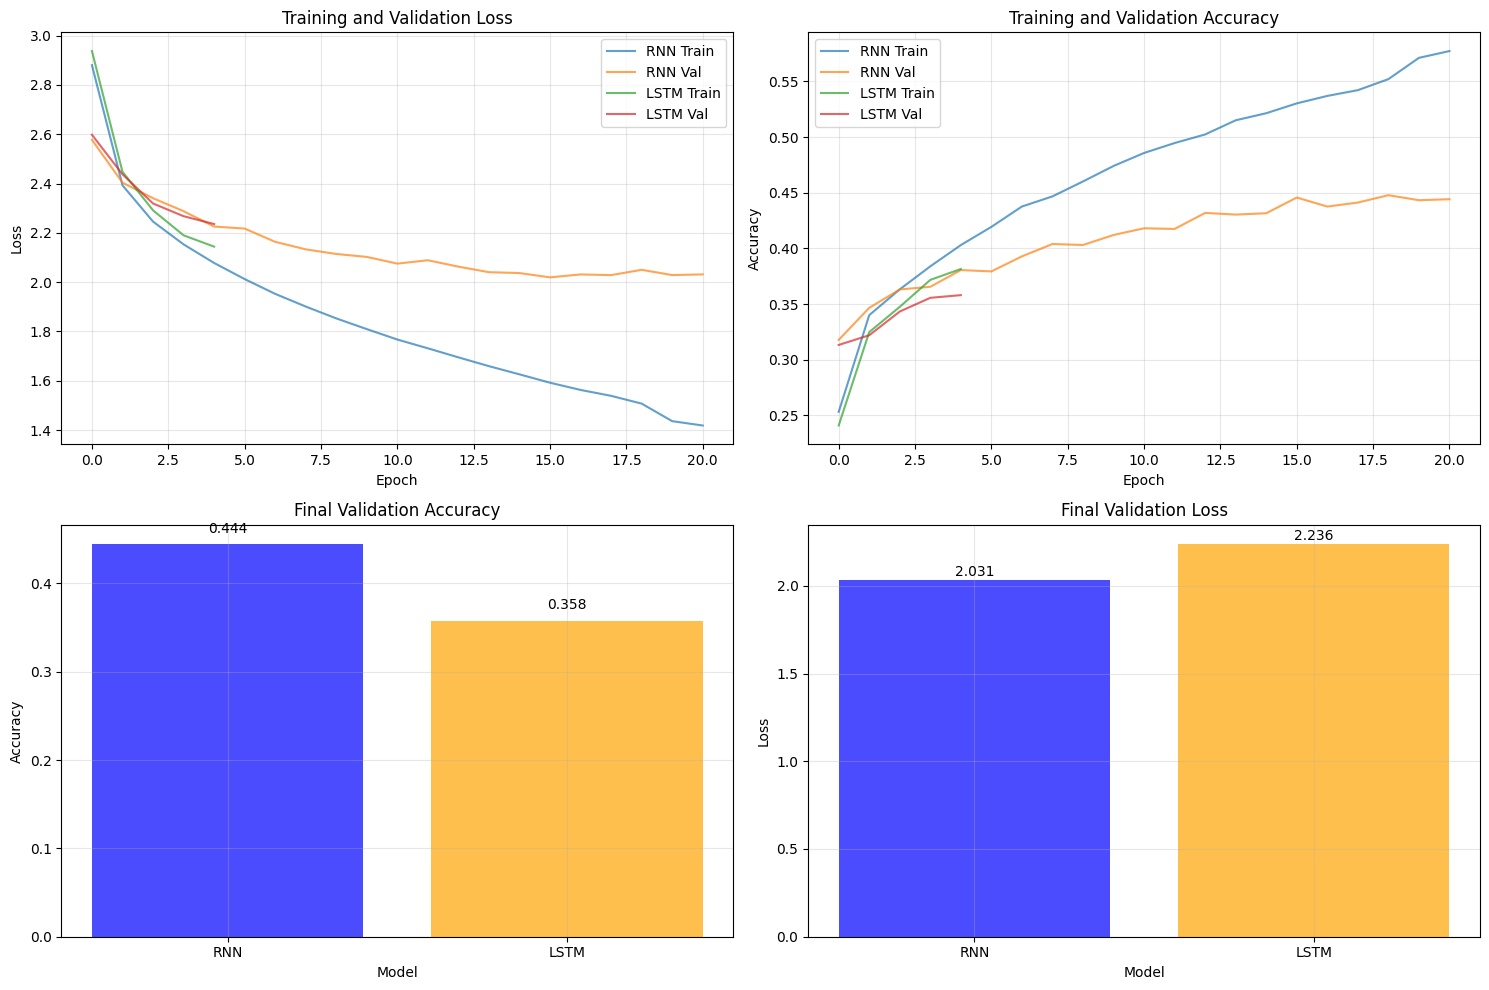

In [6]:
def plot_training_comparison(rnn_history, lstm_history):
    """Compare training progress of RNN vs LSTM"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss comparison
    ax1.plot(rnn_history.history['loss'], label='RNN Train', alpha=0.7)
    ax1.plot(rnn_history.history['val_loss'], label='RNN Val', alpha=0.7)
    ax1.plot(lstm_history.history['loss'], label='LSTM Train', alpha=0.7)
    ax1.plot(lstm_history.history['val_loss'], label='LSTM Val', alpha=0.7)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy comparison
    ax2.plot(rnn_history.history['accuracy'], label='RNN Train', alpha=0.7)
    ax2.plot(rnn_history.history['val_accuracy'], label='RNN Val', alpha=0.7)
    ax2.plot(lstm_history.history['accuracy'], label='LSTM Train', alpha=0.7)
    ax2.plot(lstm_history.history['val_accuracy'], label='LSTM Val', alpha=0.7)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Final performance comparison
    rnn_final_acc = rnn_history.history['val_accuracy'][-1]
    lstm_final_acc = lstm_history.history['val_accuracy'][-1]
    rnn_final_loss = rnn_history.history['val_loss'][-1]
    lstm_final_loss = lstm_history.history['val_loss'][-1]
    
    models = ['RNN', 'LSTM']
    accuracies = [rnn_final_acc, lstm_final_acc]
    losses = [rnn_final_loss, lstm_final_loss]
    
    x_pos = np.arange(len(models))
    
    ax3.bar(x_pos, accuracies, color=['blue', 'orange'], alpha=0.7)
    ax3.set_title('Final Validation Accuracy')
    ax3.set_xlabel('Model')
    ax3.set_ylabel('Accuracy')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(models)
    ax3.grid(True, alpha=0.3)
    
    for i, v in enumerate(accuracies):
        ax3.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    ax4.bar(x_pos, losses, color=['blue', 'orange'], alpha=0.7)
    ax4.set_title('Final Validation Loss')
    ax4.set_xlabel('Model')
    ax4.set_ylabel('Loss')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(models)
    ax4.grid(True, alpha=0.3)
    
    for i, v in enumerate(losses):
        ax4.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return rnn_final_acc, lstm_final_acc, rnn_final_loss, lstm_final_loss

# Plot comparison
print("Generating training comparison...")
final_metrics = plot_training_comparison(rnn_history, lstm_history)
rnn_final_acc, lstm_final_acc, rnn_final_loss, lstm_final_loss = final_metrics

# Text Generation with Temperature

In [7]:
def predict_next_chars(model, preprocessor, seed_text, num_chars=200, temperature=1.0):
    """Generate text using the trained model with temperature sampling"""
    
    generated = seed_text
    sequence = seed_text[-preprocessor.sequence_length:]
    
    print(f"Seed: '{seed_text}'")
    print("Generating text...\n")
    
    for i in range(num_chars):
        # Convert current sequence to numerical representation
        x = np.array([preprocessor.char_to_idx[char] for char in sequence])
        x = x.reshape(1, -1)
        
        # Get prediction
        preds = model.predict(x, verbose=0)[0]
        
        # Apply temperature
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        
        # Sample from distribution
        next_idx = np.random.choice(len(preds), p=preds)
        next_char = preprocessor.idx_to_char[next_idx]
        
        # Append to generated text and update sequence
        generated += next_char
        sequence = sequence[1:] + next_char
        
        # Stop if we predict reasonable end
        if next_char in '.!?\n' and i > num_chars // 2:
            break
    
    print(f"Generated text ({len(generated)} characters):")
    print('-' * 50)
    print(generated)
    print('-' * 50)
    return generated

# Test both models with fairy tale seeds
seeds = [
    "Once upon a time",
    "The king said",
    "In a faraway land",
    "The princess was"
]

for seed in seeds:
    if len(seed) >= preprocessor.sequence_length:
        current_seed = seed[-preprocessor.sequence_length:]
    else:
        current_seed = seed
    
    print("\n" + "="*60)
    print(f"SEED: '{seed}'")
    print("="*60)
    
    print("\nRNN PREDICTIONS (temperature=0.8):")
    rnn_generated = predict_next_chars(rnn_model, preprocessor, current_seed, 
                                     num_chars=150, temperature=0.8)
    
    print("\nLSTM PREDICTIONS (temperature=0.8):")
    lstm_generated = predict_next_chars(lstm_model, preprocessor, current_seed, 
                                      num_chars=150, temperature=0.8)


SEED: 'Once upon a time'

RNN PREDICTIONS (temperature=0.8):
Seed: 'Once upon a time'
Generating text...

Generated text (129 characters):
--------------------------------------------------
Once upon a timer; and the Gient were place,” said.  In made tille to the rose! deat lot love upray the bugssacked the The sarce.
--------------------------------------------------

LSTM PREDICTIONS (temperature=0.8):
Seed: 'Once upon a time'
Generating text...

Generated text (166 characters):
--------------------------------------------------
Once upon a time Tem lorivte mare ther hes the hanon adr che oske uithe te, toatI winiret bar the re rinn thise so wfe, toruYe hiseind sy he fn thee the thils inprtea
--------------------------------------------------

SEED: 'The king said'

RNN PREDICTIONS (temperature=0.8):
Seed: 'The king said'
Generating text...

Generated text (156 characters):
--------------------------------------------------
The king said, in a parisy what have flose brinces wand to 

# Memory and Pattern Analysis

In [8]:
def analyze_learned_patterns(model, preprocessor, test_sequences):
    """Analyze what patterns the model has learned"""
    
    print("\n" + "="*70)
    print("ANALYZING LEARNED PATTERNS")
    print("="*70)
    
    for seq in test_sequences:
        if len(seq) >= preprocessor.sequence_length:
            test_seq = seq[-preprocessor.sequence_length:]
        else:
            test_seq = seq
        
        print(f"\nContext: '{seq}'")
        
        # Model prediction
        x_test = np.array([preprocessor.char_to_idx[char] for char in test_seq])
        x_test = x_test.reshape(1, -1)
        
        pred = model.predict(x_test, verbose=0)[0]
        
        # Top 5 predictions
        top_5 = np.argsort(pred)[-5:][::-1]
        
        print("Top 5 next character predictions:")
        for idx in top_5:
            char = preprocessor.idx_to_char[idx]
            prob = pred[idx]
            char_display = repr(char).replace("'", "")  # Handle special characters
            print(f"  {char_display}: {prob:.3f}")

# Test patterns
test_sequences = [
    "the ",
    "and the ",
    "Once upon a ",
    "king ",
    "princess ",
    "The dragon "
]

print("RNN Learned Patterns:")
analyze_learned_patterns(rnn_model, preprocessor, test_sequences)

print("\nLSTM Learned Patterns:")
analyze_learned_patterns(lstm_model, preprocessor, test_sequences)

RNN Learned Patterns:

ANALYZING LEARNED PATTERNS

Context: 'the '
Top 5 next character predictions:
  S: 0.239
  T: 0.063
  M: 0.056
  G: 0.055
  N: 0.054

Context: 'and the '
Top 5 next character predictions:
  s: 0.155
  R: 0.063
  S: 0.053
  f: 0.046
  b: 0.045

Context: 'Once upon a '
Top 5 next character predictions:
  d: 0.203
  s: 0.109
  g: 0.092
  v: 0.072
  l: 0.068

Context: 'king '
Top 5 next character predictions:
  I: 0.137
  h: 0.123
  a: 0.087
  t: 0.085
  “: 0.083

Context: 'princess '
Top 5 next character predictions:
  a: 0.119
  o: 0.119
  c: 0.106
  t: 0.105
  s: 0.088

Context: 'The dragon '
Top 5 next character predictions:
  t: 0.213
  s: 0.083
  a: 0.054
  n: 0.052
  b: 0.052

LSTM Learned Patterns:

ANALYZING LEARNED PATTERNS

Context: 'the '
Top 5 next character predictions:
  t: 0.077
  a: 0.066
  h: 0.058
  i: 0.046
  w: 0.041

Context: 'and the '
Top 5 next character predictions:
  t: 0.176
  a: 0.093
  h: 0.073
  i: 0.061
  w: 0.051

Context: 'Once upon 

# Quick Training Version (If Dataset is Large)

In [11]:
# Quick training with smaller models
def quick_train():
    """Quick training with smaller models and less data"""
    print("Using quick training setup...")
    
    # Use smaller sequence length and step size
    preprocessor_quick = CharRNNPreprocessor(text[:50000], sequence_length=30)  # First 50K chars
    X_quick, y_quick = preprocessor_quick.prepare_data(step=5)  # Use every 5th sequence
    y_quick_categorical = tf.keras.utils.to_categorical(y_quick, num_classes=len(preprocessor_quick.chars))
    
    # Build smaller models
    rnn_quick = build_rnn_model(len(preprocessor_quick.chars), 30, hidden_units=64)
    lstm_quick = build_lstm_model(len(preprocessor_quick.chars), 30, hidden_units=64)
    
    # Quick training
    print("Quick training RNN...")
    rnn_quick.fit(X_quick, y_quick_categorical, batch_size=64, epochs=20, validation_split=0.2, verbose=1)
    
    print("Quick training LSTM...")
    lstm_quick.fit(X_quick, y_quick_categorical, batch_size=64, epochs=20, validation_split=0.2, verbose=1)
    
    # Quick test
    seed = "Once upon a time"
    if len(seed) >= 30:
        test_seed = seed[-30:]
    else:
        test_seed = seed
    
    print("\nRNN Quick Test:")
    predict_next_chars(rnn_quick, preprocessor_quick, test_seed, num_chars=100)
    
    print("\nLSTM Quick Test:")
    predict_next_chars(lstm_quick, preprocessor_quick, test_seed, num_chars=100)
    
    return rnn_quick, lstm_quick, preprocessor_quick

# Uncomment if you want quicker results
# rnn_quick, lstm_quick, preprocessor_quick = quick_train()